In [48]:
# Objectives
# + To familiarize with `matplotlib` (we will use a dataset on firms' publishing activity and R&D expenditures)
# + To explore a few network layout algorithms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import os.path as path


First let's load the data and see what we have as a first line exploration

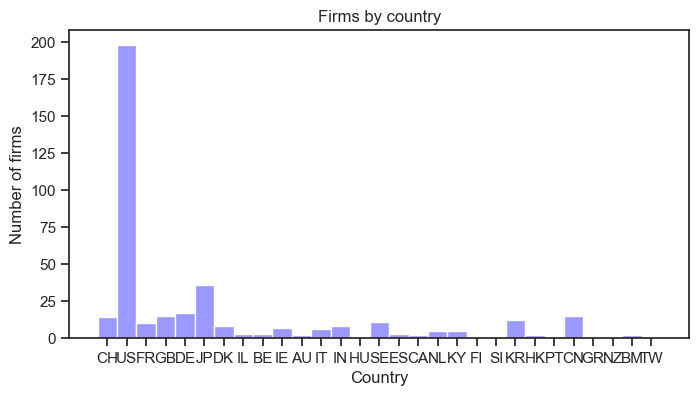

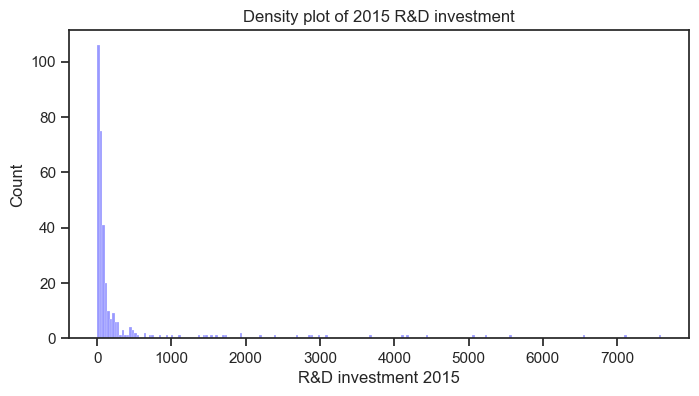

In [49]:

# Load the data
url = "https://github.com/QEDditch/995N1-2023/blob/main/data/scoreboard_firms_pharma_healthcare.csv"

my_data = pd.read_csv(url)

# Examine the distribution of firms by country
plt.figure(figsize=(8, 4))
sns.histplot(data=my_data, x="isocountrycode", color="blue", alpha=0.4)
plt.title("Firms by country")
plt.xlabel("Country")
plt.ylabel("Number of firms")
plt.show()

# Explore the distribution of R&D investment in 2015
plt.figure(figsize=(8, 4))
sns.histplot(data=my_data, x="rd2015", color="blue", alpha=0.4)
plt.title("Density plot of 2015 R&D investment")
plt.xlabel("R&D investment 2015")
plt.show()


So far so good but a bit limiting. Let's try transforming things to make it a bit easier to read

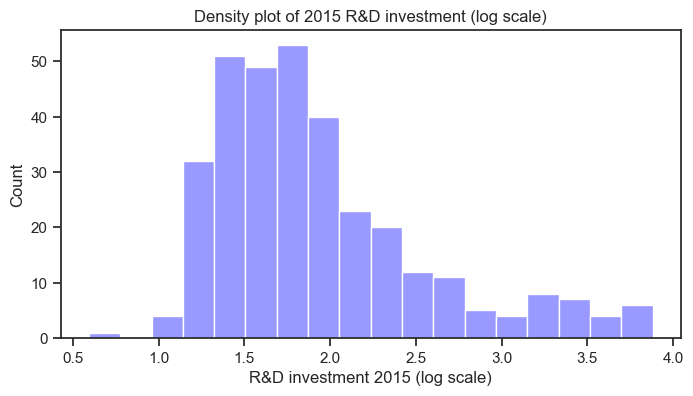

In [50]:


# Transform R&D investment using the log function
plt.figure(figsize=(8, 4))
sns.histplot(data=my_data, x=np.log10(my_data["rd2015"]), color="blue", alpha=0.4)
plt.title("Density plot of 2015 R&D investment (log scale)")
plt.xlabel("R&D investment 2015 (log scale)")
plt.show()


Fun time now!

# Exercise 1: Reproduce the density plot for the variable `pubs.2015`

## Transform the data into a tidy format for exploration


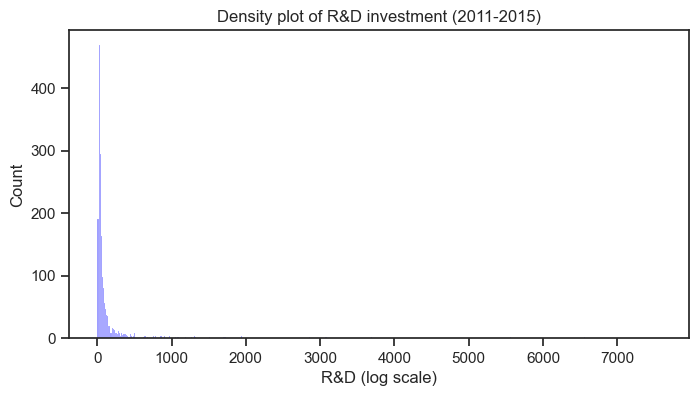

In [51]:
columns = ["rd2011", "rd2012", "rd2013", "rd2014", "rd2015"]
rd_data = my_data[["ID"] + columns]
rd_data = rd_data.melt(id_vars="ID", var_name="year", value_name="rd")

plt.figure(figsize=(8, 4))
sns.histplot(data=rd_data, x="rd", color="blue", alpha=0.4)
plt.title("Density plot of R&D investment (2011-2015)")
plt.xlabel("R&D (log scale)")
plt.show()



## Explore relationships between variables using GGally


c:\Users\David Eggleton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
c:\Users\David Eggleton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
c:\Users\David Eggleton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
c:\Users\David Eggleton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
c:\Users\David Eggleton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
c:\Users\David Eggleton\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: D

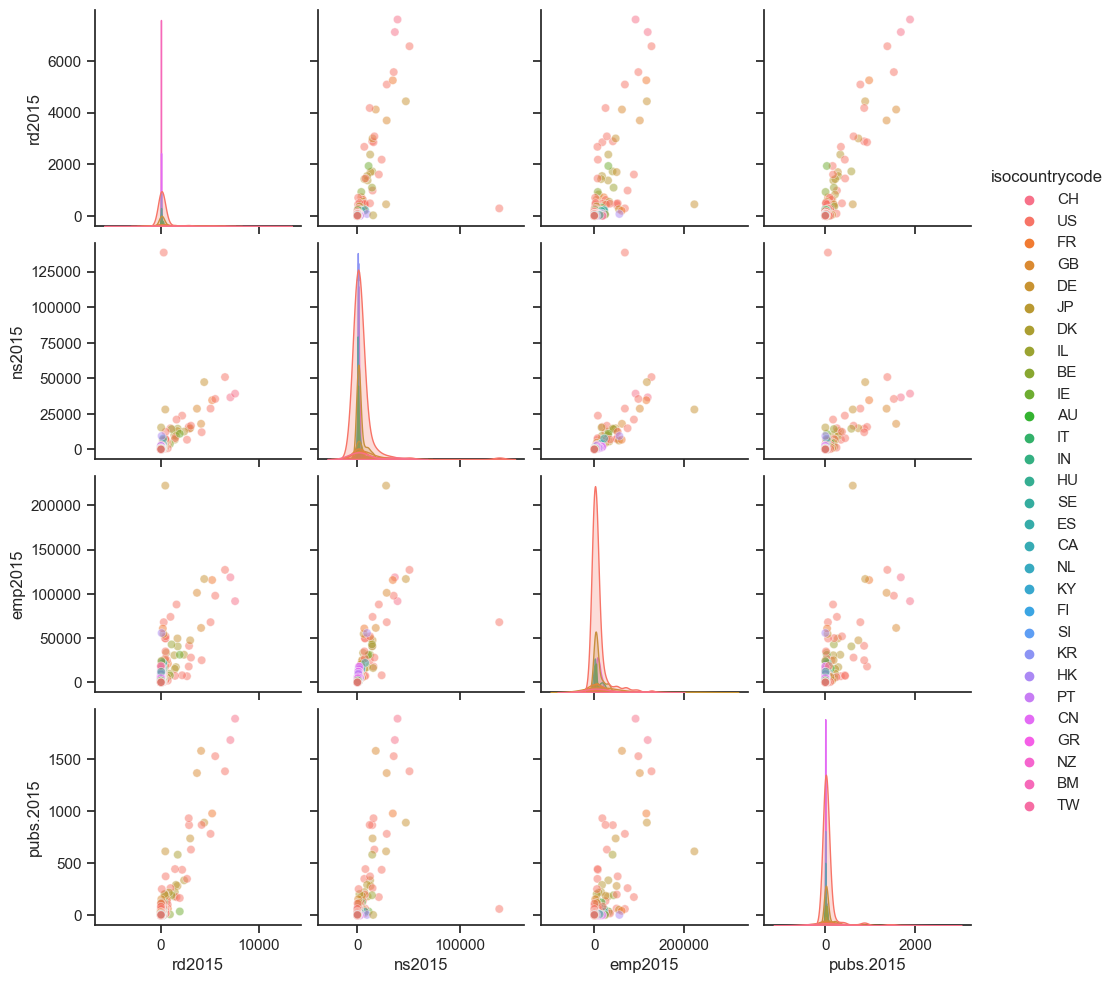

In [52]:
sns.set(style="ticks")
sns.pairplot(data=my_data, vars=["rd2015", "ns2015", "emp2015", "pubs.2015"], hue="isocountrycode", plot_kws={"alpha": 0.5})
plt.show()

## Focus on the relationship between R&D investment and publications activity


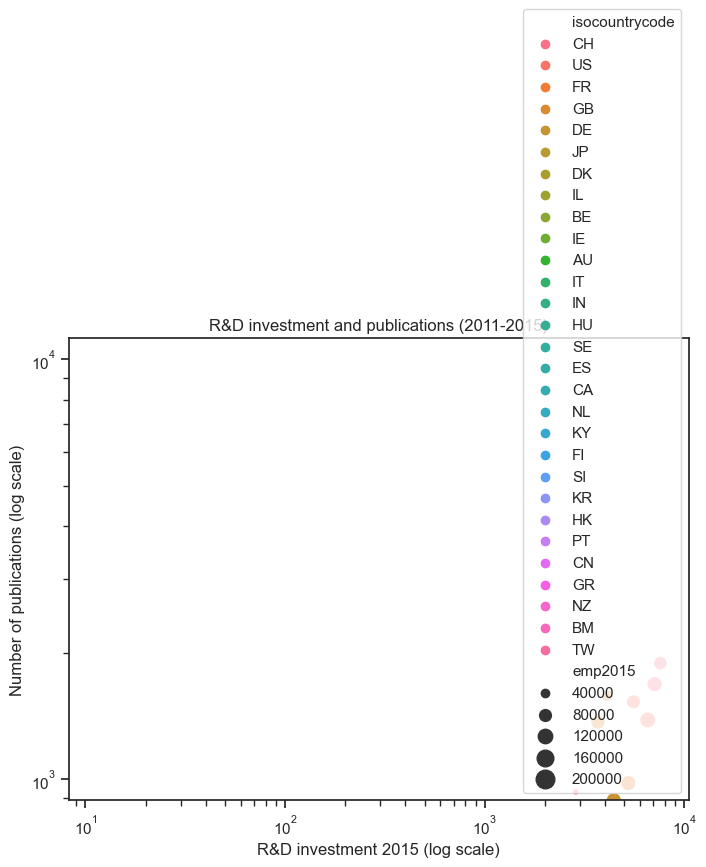

In [53]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=my_data, x="rd2015", y="pubs.2015", hue="isocountrycode", size="emp2015", sizes=(0, 200))
plt.xscale("log")
plt.yscale("log")
plt.title("R&D investment and publications (2011-2015)")
plt.xlabel("R&D investment 2015 (log scale)")
plt.ylabel("Number of publications (log scale)")
plt.legend(loc="lower right")
plt.show()



## Use gghighlight to identify firms with less than 10,000 employees


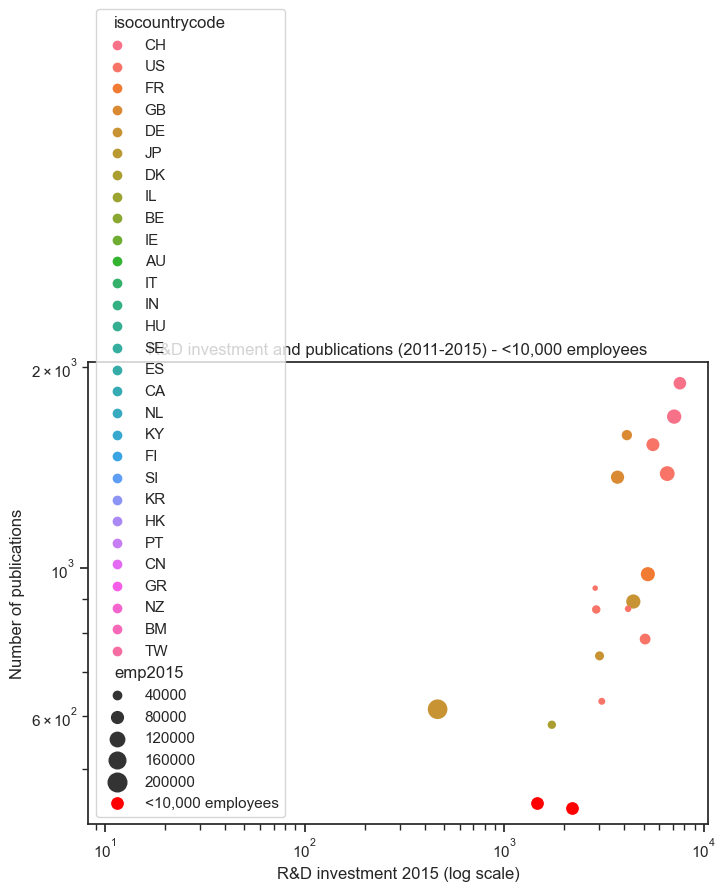

In [54]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=my_data, x="rd2015", y="pubs.2015", hue="isocountrycode", size="emp2015", sizes=(0, 200))
plt.xscale("log")
plt.yscale("log")
plt.title("R&D investment and publications (2011-2015) - <10,000 employees")
plt.xlabel("R&D investment 2015 (log scale)")
plt.ylabel("Number of publications")
plt.legend(loc="lower right")
sns.scatterplot(data=my_data[my_data["emp2015"] < 10000], x="rd2015", y="pubs.2015", color="red", s=100, label="<10,000 employees")
plt.show()



# Exercise 2: Reproduce scatterplots for firms with 10,000-50,000 employees and >50,000 employees

## Combine all charts using the patchwork package


In [55]:
# Select and pivot 'rd' columns
my_data_rd = my_data.melt(id_vars=['ID'], value_vars=['rd2011', 'rd2012', 'rd2013', 'rd2014', 'rd2015'], var_name='year', value_name='rd')
my_data_rd['year'] = my_data_rd['year'].str.replace('rd', '')

# Select and pivot 'ns' columns
my_data_ns = my_data.melt(id_vars=['ID'], value_vars=['ns2011', 'ns2012', 'ns2013', 'ns2014', 'ns2015'], var_name='year', value_name='ns')
my_data_ns['year'] = my_data_ns['year'].str.replace('ns', '')

# Select and pivot 'emp' columns
my_data_emp = my_data.melt(id_vars=['ID'], value_vars=['emp2011', 'emp2012', 'emp2013', 'emp2014', 'emp2015'], var_name='year', value_name='emp')
my_data_emp['year'] = my_data_emp['year'].str.replace('emp', '')

# Select and pivot 'pubs' columns
my_data_pub = my_data.melt(id_vars=['ID'], value_vars=['pubs.2011', 'pubs.2012', 'pubs.2013', 'pubs.2014', 'pubs.2015'], var_name='year', value_name='pubs')
my_data_pub['year'] = my_data_pub['year'].str.replace('pubs.', '')

# Perform full joins
my_data_tidy = pd.merge(my_data_rd, my_data_ns, on=['ID', 'year'], how='outer')
my_data_tidy = pd.merge(my_data_tidy, my_data_emp, on=['ID', 'year'], how='outer')
my_data_tidy = pd.merge(my_data_tidy, my_data_pub, on=['ID', 'year'], how='outer')
my_data_tidy = pd.merge(my_data_tidy, my_data[['ID', 'isocountrycode']], on=['ID'], how='outer')

# Display the first few rows
print(my_data_tidy.head())

       ID  year           rd           ns       emp  pubs isocountrycode
0  ID0001  2011  6657.240398  42466.82727  123686.0  1411             CH
1  ID0001  2012  6737.002563  41094.19290  127724.0  1512             CH
2  ID0001  2013  7173.519143  41998.40582  135696.0  1608             CH
3  ID0001  2014  7234.432237  43211.53856  133413.0  1597             CH
4  ID0001  2015  7106.088095  36536.16948  118700.0  1684             CH


C:\Temp\ipykernel_31872\1800755779.py:15: FutureWarning: The default value of regex will change from True to False in a future version.


We can use the SNS to explore relationships between variables by years using the new tidy data structure.

No handles with labels found to put in legend.


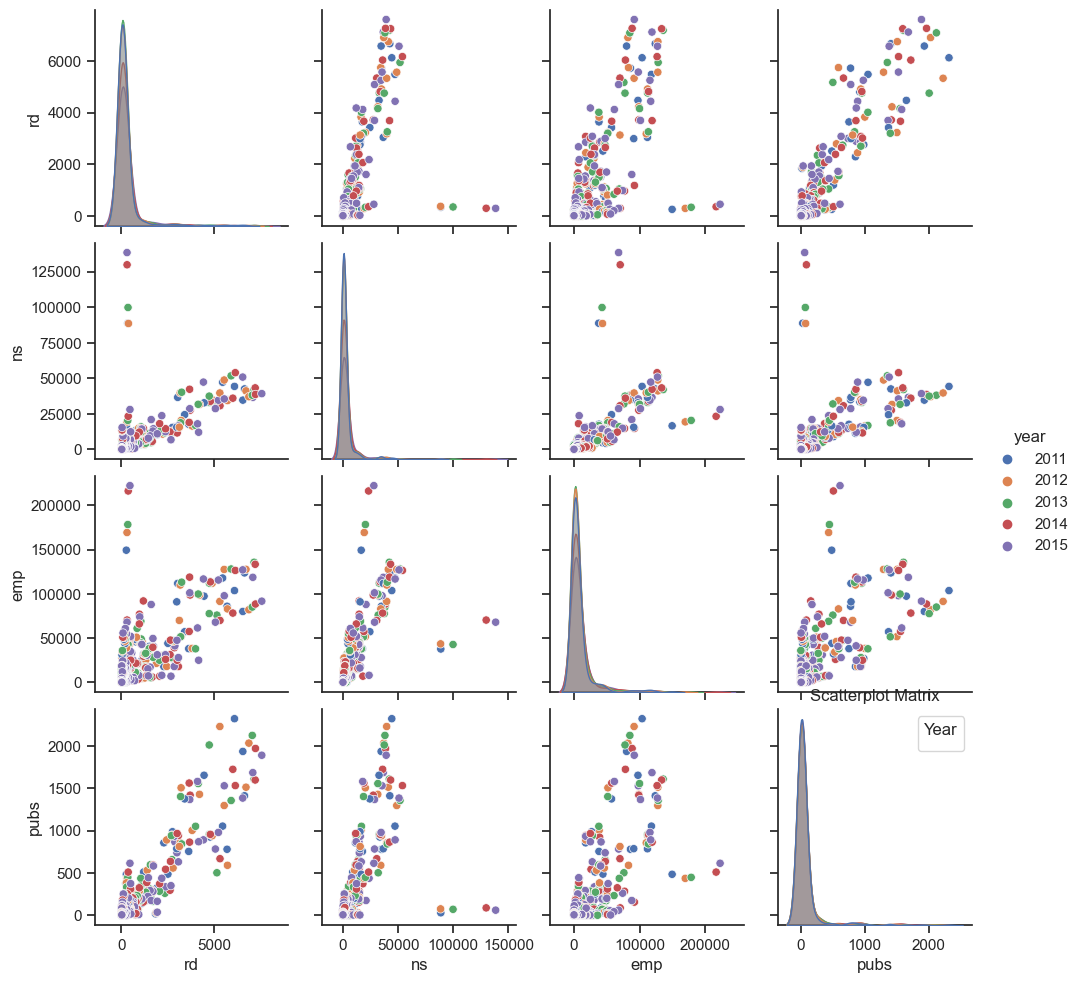

In [56]:
# Assuming 'my_data_tidy' is a DataFrame containing your tidy data

# Define the columns you want to include in the scatterplot matrix
columns_to_plot = ["rd", "ns", "emp", "pubs"]

# Set the color palette based on the 'year' column
sns.set(style="ticks")
g = sns.pairplot(my_data_tidy, hue="year", vars=columns_to_plot)

# Customize the plot further if needed
# For example, you can add a legend or set the title
plt.legend(title='Year')
plt.title("Scatterplot Matrix")

# Show the plot
plt.show()

We can focus on the relationship between a firm's R&D investment and publications activity. We can also increase the size of the points on the basis of the number of employees and color them on the basis of country data. We will need to simplify the latter first.

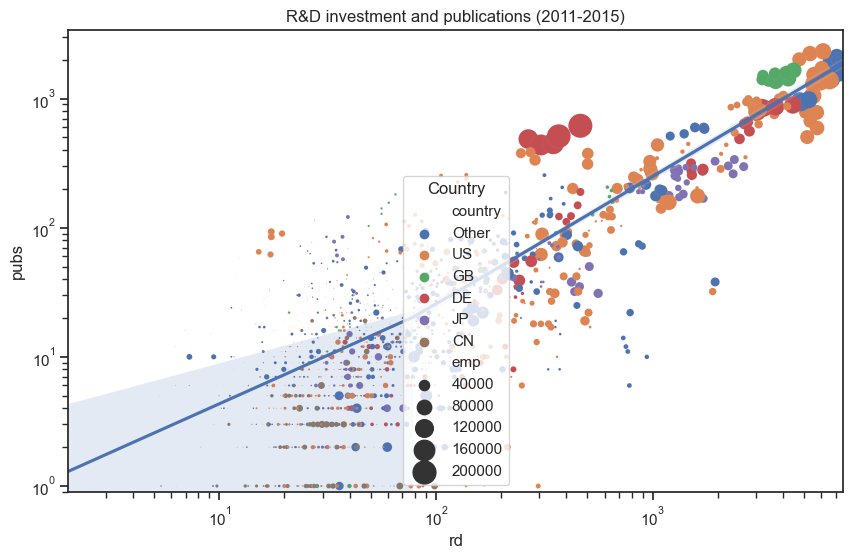

In [57]:
my_data_tidy['country'] = my_data_tidy['isocountrycode'].apply(lambda x: 'Other' if x not in ["US", "CN", "JP", "DE", "GB"] else x)

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=my_data_tidy, x='rd', y='pubs', hue='country', size='emp', sizes=(0, 300))
scatter_plot.set(xscale='log', yscale='log')
scatter_plot.set_title("R&D investment and publications (2011-2015)")
scatter_plot.set_xlabel("R&D (log scale)")
scatter_plot.set_ylabel("Number of publications (log scale)")
scatter_plot.legend(title='Country', loc='lower center')

# Add a regression line
sns.regplot(data=my_data_tidy, x='rd', y='pubs', scatter=False, ax=scatter_plot)

# Show the plot
plt.show()

We can use the `gghighlight` package to identify firms with less than 10,000 employees...

In [61]:
from plotnine import ggplot, aes, geom_point, geom_smooth, scale_x_log10, scale_y_log10, labs, theme
import matplotlib

# Assuming 'my_data_tidy' is a DataFrame containing your tidy data

# Create the ggplot object
plot = (
    ggplot(my_data_tidy, aes(x='rd', y='pubs+1')) +
    geom_point(aes(color='country', size='emp')) +
    scale_x_log10() +
    scale_y_log10() +
    labs(
        title="R&D investment and publications (2011-2015) - <10,000 employees",
        x="R&D (log scale)",
        y="Number of publications",
    )
)

# Highlight points with emp < 10000
highlighted_plot = plot + geom_point(data=my_data_tidy[my_data_tidy['emp'] < 10000], color='red', size=3)

# Add a regression line
highlighted_plot = highlighted_plot + geom_smooth()

# Display the plot
print(highlighted_plot)

ModuleNotFoundError: No module named 'matplotlib.layout_engine'

... or firms with 10,000-50,000 employees...

In [ ]:
# Create the ggplot object
plot = (
    ggplot(my_data_tidy, aes(x='rd', y='pubs+1')) +
    geom_point(aes(color='country', size='emp')) +
    scale_size_continuous(range=(0, 3)) +
    geom_smooth() +
    scale_x_log10() +
    scale_y_log10() +
    labs(
        title="R&D investment and publications (2011-2015) - 10,000-50,000 employees",
        x="R&D (log scale)",
        y="Number of publications",
    ) +
    gghighlight((my_data_tidy['emp'] >= 10000) & (my_data_tidy['emp'] <= 50000), keep_scales=True)
)

# Display the plot
print(plot)

... or firms with more than 50,000 employees.

In [ ]:
plot = (
    ggplot(my_data_tidy, aes(x='rd', y='pubs+1')) +
    geom_point(aes(color='country', size='emp')) +
    scale_size_continuous(range=(0, 3)) +
    geom_smooth() +
    scale_x_log10() +
    scale_y_log10() +
    labs(
        title="R&D investment and publications (2011-2015) - 10,000-50,000 employees",
        x="R&D (log scale)",
        y="Number of publications",
    ) +
    gghighlight((my_data_tidy['emp'] > 50000), keep_scales=True)
)

# Display the plot
print(plot)

NameError: name 'my_data_tidy' is not defined

We can combine all these charts using a grid layout.

In [ ]:
g1 = (
    ggplot(my_data_tidy, aes(x='rd', y='pubs+1')) +
    geom_point(aes(color='country', size='emp')) +
    scale_size(range=(0, 3)) +
    geom_smooth() +
    scale_x_log10() +
    scale_y_log10() +
    labs(
        title="R&D investment and number of publications (2011-2015)",
        x="R&D (log scale)",
        y="Number of publications",
    ) +
    theme(legend_position="bottom")
)

# Create additional plots with different titles and highlights
g2 = g1 + theme(legend_position="none", plot_title=element_text(size=7)) + labs(title="<10,000 employees")
g2 = g2 + gghighlight(my_data_tidy['emp'] < 10000, keep_scales=True)

g3 = g1 + theme(legend_position="none", plot_title=element_text(size=7)) + labs(title="10,000-50,000 employees")
g3 = g3 + gghighlight((my_data_tidy['emp'] >= 10000) & (my_data_tidy['emp'] <= 50000), keep_scales=True)

g4 = g1 + theme(legend_position="none", plot_title=element_text(size=7)) + labs(title=">50,000 employees")
g4 = g4 + gghighlight(my_data_tidy['emp'] > 50000, keep_scales=True)

# Combine the plots in a grid layout
grid_layout = (
    g1 / (g2 + g3 + g4) +
    plot_annotation(tag_levels='A')
)

# Display the grid of plots
print(grid_layout)

The `face_wrap()` function is a very helpful tool to produce multiple charts on the basis of a categorical variable. We can produce a chart for each country - that that we grouped countries into CN, DE, GB, JP, US, and Other.

In [ ]:
plot = (
    ggplot(my_data_tidy, aes(x='rd', y='pubs+1')) +
    geom_point(aes(color='country', size='emp')) +
    scale_size_continuous(range=(0, 3)) +
    geom_smooth() +
    scale_x_log10() +
    scale_y_log10() +
    labs(
        title="R&D investment and number of publications (2011-2015)",
        x="R&D (log scale)",
        y="Number of publications",
    ) +
    theme(legend_position="bottom") +
    facet_wrap('~country', nrow=2)  # Adjust 'nrow' as needed for rows in the grid
)

# Customize facet labels if desired
plot = plot + theme(strip_text=element_text(size=8))

# Display the plot
print(plot)

Similarly, we can produce a chart by year.

In [ ]:
plot = (
    ggplot(my_data_tidy, aes(x='rd', y='pubs+1')) +
    geom_point(aes(color='country', size='emp')) +
    scale_size_continuous(range=(0, 3)) +
    geom_smooth() +
    scale_x_log10() +
    scale_y_log10() +
    labs(
        title="R&D investment and number of publications (2011-2015)",
        x="R&D (log scale)",
        y="Number of publications",
    ) +
    theme(legend_position="bottom") +
    facet_wrap('~year', nrow=2)  # Adjust 'nrow' as needed for rows in the grid
)

# Customize facet labels if desired
plot = plot + theme(strip_text=element_text(size=8))

# Display the plot
print(plot)

#Exercise 3: Produce a chart that compares R&D investment and number of publications for UK firms (10 minutes). (Have fun!)